# TSP - MTZ

$$
\begin{align}
    \text{min} \quad & \sum_{i, j \in A}d_{i, j} x_{i, j} \\
    \text{s.t.} \quad & \sum_{j \in V} x_{i, j} = \sum_{j \in V} x_{j, i} = 1 & \forall ~ i \in V\\
    & u_{i} + 1 \leq u_{j} + (|V| - 1) (1 - x_{i, j}) & \forall ~ i, j \in A: j \neq 0\\
    & x_{i, j} \in \left \{ 0, 1 \right \} & \forall ~ i, j \in A\\
\end{align}
$$

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Create instance

In [2]:
N = 30  # Number of points
np.random.seed(12)
coordinates = np.random.random((N, 2))
D = squareform(pdist(coordinates))

## pyomo model

In [5]:
# Initialize ConcreteModel
model = pyo.ConcreteModel()

In [6]:
# Sets nodes and arcs
model.V = pyo.Set(initialize=range(N))
model.A = pyo.Set(
    initialize=[(i, j) for i in range(N) for j in range(N) if i != j]
)

In [7]:
# Parameter pairwise distances
model.d = pyo.Param(model.A, initialize={(i, j): D[i, j] for i, j in model.A})

In [8]:
# Variables
model.x = pyo.Var(model.A, within=pyo.Binary)
model.u = pyo.Var(model.V, within=pyo.NonNegativeReals)

In [9]:
# Constraints
def arcs_in(model, i):
    return sum(model.x[:, i]) == 1.0


def arcs_out(model, i):
    return sum(model.x[i, :]) == 1.0


def precedence(model, i, j):
    if j != model.V.first():
        return model.u[i] + 1.0 <= model.u[j] + (len(model.V) - 1) * (1 - model.x[i, j])
    else:
        return pyo.Constraint.Skip


model.arcs_in = pyo.Constraint(model.V, rule=arcs_in)
model.arcs_out = pyo.Constraint(model.V, rule=arcs_out)
model.precedence = pyo.Constraint(model.A, rule=precedence)

In [10]:
# Objective
def obj(model):
    return sum(
        model.d[i, j] * model.x[i, j]
        for i, j in model.A
    )


model.obj = pyo.Objective(rule=obj, sense=pyo.minimize)

## Solve

In [11]:
solver = pyo.SolverFactory("appsi_highs")
res = solver.solve(model, tee=True)

Presolving model
901 rows, 899 cols, 4234 nonzeros
901 rows, 899 cols, 4234 nonzeros

Solving MIP model with:
   901 rows
   899 cols (870 binary, 0 integer, 0 implied int., 29 continuous)
   4234 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.1s
         0       0         0   0.00%   3.533653823     inf                  inf        0      0      0       111     0.1s
 C       0       0         0   0.00%   4.593316937     10.85090957       57.67%      369     67      8       195     0.5s
 L       0       0         0   0.00%   4.632512227     5.029207219        7.89%     1303     75      8       500     5.0s
 L       0       0         0   0.00%   4.632512227     4.955

In [12]:
def find_tour(model):
    Q = [v for v in model.V]
    node = Q.pop(0)
    tour = [node]
    while len(Q) > 0:
        for other in Q:
            if np.isclose(model.x[node, other].value, 1, atol=1e-1):
                Q.remove(other)
                node = other
                tour.append(node)
    tour.append(tour[0])
    return tour

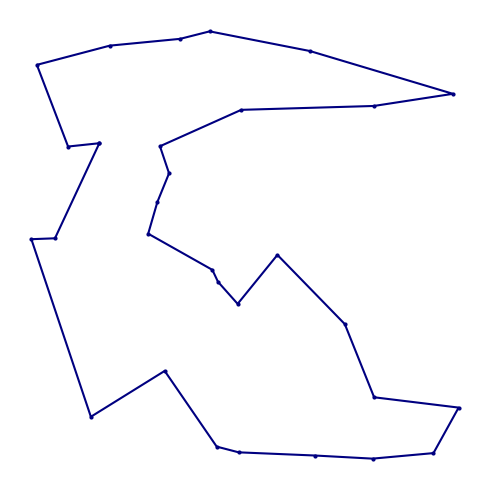

In [13]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)

tour = np.array(find_tour(model))
ax.scatter(coordinates[tour, 0], coordinates[tour, 1], color="navy", s=4)
ax.plot(coordinates[tour, 0], coordinates[tour, 1], color="navy")
ax.axis('off')

fig.tight_layout()
plt.show()